In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from torchvision.datasets import FashionMNIST
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
import math

In [2]:
# Controlla la disponibilità della GPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # Imposta il dispositivo sulla GPU
else:
    device = torch.device("cpu")  # Se la GPU non è disponibile, utilizza la CPU

print(device)

cuda


In [67]:
path_to_model = "/content/model.pth"
path_to_output = "/content/my" #crea la cartella "my"

# Dataset 2 (digits)

In [3]:
#Abbiamo 1797 campioni, ciascuno 8x8. Ogni immagine è organizzata come un vettore di 64 pixel
digits_dataset = load_digits()

print(digits_dataset.data.shape)

(1797, 64)


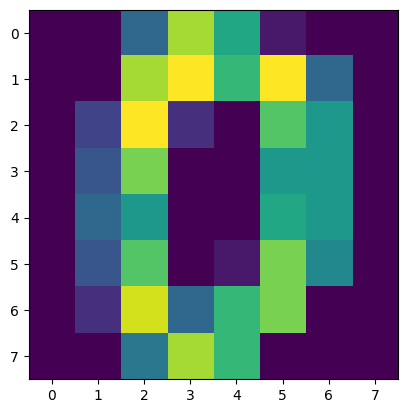

In [4]:
from matplotlib import pyplot as plt
#ogni riga è una immagine. Vediamo un esempio
img1 = digits_dataset.data[0]
#facciamo il reshape del vettore di 64 elementi in 8x8
img1 = np.reshape(img1, (8,8))
plt.imshow(img1)


In [5]:
#essendo ogni riga una immagine allora prendo le prime 1000 come training set, 350 come validation set e il resto come test set
training_data = digits_dataset.data[0:1000].astype(np.float32)
validation_data = digits_dataset.data[1000:1350].astype(np.float32)
test_data = digits_dataset.data[1350:].astype(np.float32)

In [6]:
#hyperparameters
input_shape_image = 8*8
possible_pixel_values = 17 # ossia {0,1,...,16}

# Dataset 5 (Frey Face)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import scipy.io

# Carica il file .mat
data = scipy.io.loadmat('/content/drive/MyDrive/Generative_AI/datasets/frey_rawface.mat')

In [ ]:
data = data['ff'].T
data

array([[ 81, 136, 167, ..., 152, 158, 164],
       [ 85, 138, 165, ..., 167, 178, 184],
       [ 87, 139, 166, ..., 172, 177, 183],
       ...,
       [ 80,  84, 155, ..., 111, 186, 182],
       [ 73,  86, 131, ..., 135, 167, 177],
       [ 58,  89, 110, ..., 166, 177, 184]], dtype=uint8)

In [ ]:
data = data.reshape(1965,28,20)

In [ ]:
from PIL import Image
# Converte la matrice in un oggetto immagine di tipo Pillow
image_list = [Image.fromarray(data[i]) for i in range(data.shape[0])]

# Ridimensiona tutte le immagini nella lista all'altezza e larghezza desiderate
new_image_list = [image.resize((28, 28)) for image in image_list]

# Converti le immagini ridimensionate in una nuova matrice
resized_data = np.array([np.array(image) for image in new_image_list])

max_value = 20
#normalizza
img_normalized = np.round((resized_data / 255) * max_value).astype(int)

(28, 28)


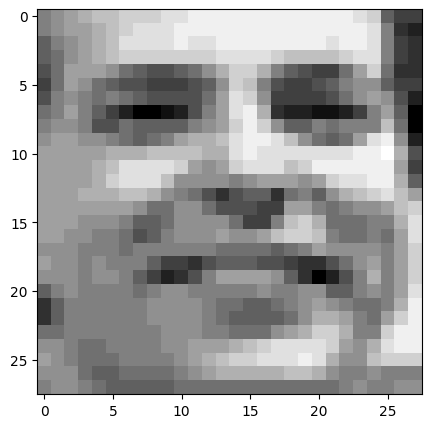

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (5, 5) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
#ogni riga è una immagine. Vediamo un esempio
img1 = img_normalized[1120]
print(img1.shape)
plt.imshow(img1)


In [ ]:
#essendo ogni riga una immagine allora prendo le prime 1000 come training set, 350 come validation set e il resto come test set
training_data = img_normalized[0:1300].astype(np.float32)
validation_data = img_normalized[1300:1800].astype(np.float32)
test_data = img_normalized[1800:].astype(np.float32)

In [ ]:
#hyperparameters
resize_to = 28
input_shape_image = resize_to*resize_to
possible_pixel_values = max_value+1 # ossia {0,1,...,max_value}

# Dataset 6 (Celeb face)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path_to_model = "/content/drive/MyDrive/Generative_AI/datasets/celebA/model/model_prior_flow.pth"
path_to_output = "/content/drive/MyDrive/Generative_AI/datasets/celebA/output/flow_"

preprocessing

In [ ]:
import os
import numpy as np
from PIL import Image
from torchvision import transforms

# Imposta il percorso della cartella contenente le immagini
#scarica prima img_align_celeba.zip da https://drive.google.com/drive/u/0/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg
folder_path = "/content/drive/MyDrive/Generative_AI/datasets/celebA/all"

# Imposta le dimensioni di resize desiderate
resize_to = 100  # Specifica la larghezza (W) e l'altezza (H)
max_value = 20

# Crea una lista per salvare le immagini pre-elaborate
processed_images = []

# Crea una trasformazione di pre-elaborazione utilizzando torchvision.transforms.Compose
preprocess = transforms.Compose([
    transforms.Resize((resize_to,resize_to)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(0, max_value),
])

# Itera sui file nella cartella
i=0
for file_name in os.listdir(folder_path):
    print(i+1," -> ",file_name)
    i=i+1
    # Crea il percorso completo del file
    file_path = os.path.join(folder_path, file_name)

    # Carica l'immagine utilizzando PIL
    image = Image.open(file_path)

    # Applica le trasformazioni di pre-elaborazione all'immagine
    processed_image = preprocess(image)

    # Aggiungi l'immagine pre-elaborata alla lista
    processed_images.append(processed_image)

# Converte la lista di immagini in una matrice numpy
image_matrix = np.stack(processed_images)

# Ottieni le dimensioni della matrice delle immagini
N, W, H = image_matrix.shape[0], image_matrix.shape[1], image_matrix.shape[2]

# Visualizza le dimensioni della matrice delle immagini
print("Dimensioni della matrice delle immagini:", (N, W, H))


In [ ]:
import numpy as np
# Imposta il percorso del file di output
file_path = "/content/drive/MyDrive/Generative_AI/datasets/celebA/celebA.npy"

# Salva l'array nel file utilizzando np.save()
np.save(file_path, processed_images)

print("Array salvato correttamente.")


In [5]:
file_path = "/content/drive/MyDrive/Generative_AI/datasets/celebA/celebA.npy"
dataset = np.load(file_path,allow_pickle=True)

dataset.size

28638

In [6]:
image_matrix = np.stack(dataset)
image_matrix.squeeze(1).shape

(28638, 100, 100)

In [7]:
# Ottieni il numero totale di immagini
num_images = image_matrix.shape[0]

# Genera un array di indici per rimescolare le immagini
shuffled_indices = np.arange(num_images)
np.random.shuffle(shuffled_indices)

# Rimescola le immagini
image_matrix = image_matrix[shuffled_indices]

In [ ]:
from scipy import ndimage
import torchvision.transforms as transforms

resize_to = 90

# Converti ndarray in tensor PyTorch
input_tensor = torch.from_numpy(image_matrix)


# Crea una trasformazione per il ridimensionamento
resize = transforms.Resize((resize_to, resize_to))


# Applica la trasformazione al tensor
output_tensor = resize(input_tensor)

# Converti il tensor in ndarray
image_matrix = output_tensor.numpy()



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [8]:
max_value = 20
image_matrix = (image_matrix*20*max_value).astype(int)

(100, 100)


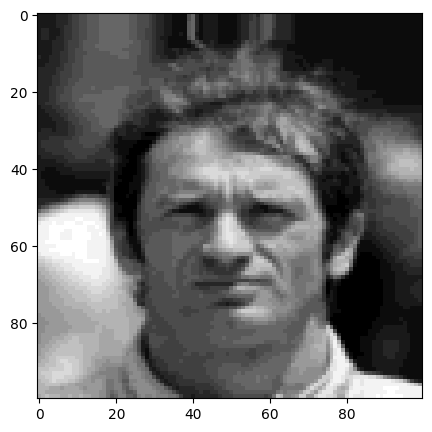

In [9]:
plt.rcParams['figure.figsize'] = (5, 5) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
#ogni riga è una immagine. Vediamo un esempio
img1= image_matrix[100].squeeze(0)
print(img1.shape)
plt.imshow(img1)


In [10]:
#essendo ogni riga una immagine allora prendo le prime 50000 come training set, 5000 come validation set e il resto come test set
training_data = image_matrix.squeeze(1)[0:26000]
validation_data = image_matrix.squeeze(1)[26000:]
#test_data = d.data[3000:4000]

In [11]:
#hyperparameters
resize_to = 100 # se hai fatto il resize prima, commenta
input_shape_image = resize_to*resize_to
possible_pixel_values = max_value+1 # ossia {0,1,...,20}

In [ ]:
import gc

#elimino per liberare memoria
del image_matrix
del dataset
#forzo il garbage collector a operare adesso
gc.collect()

0

# DataLoader

Non alleneremo la rete dandole tutti i dati, ma batch dopo batch. Creiamo quindi un DataLoader che semplicemente dividerà i dati in batch da 64 immagini (dopo averli mischiati) e ci restituirà, quando richiesto, un batch alla volta.

In [12]:
training_loader = DataLoader(training_data, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=16, shuffle=True)
#test_loader = DataLoader(test_data, batch_size=256, shuffle=True)

# Model (adattato per gpu)

hyperparameters

In [103]:
#definisco la dimensione dello spazio latente
latent_space_dimension = 64 #deve essere pari se utilizzi il Flow-based
#nuumero di hidden neurons nell'encoder e decoder
number_of_hidden_neurons = 128
#numero componenti gaussiane per il MoG o VampPrior
mog_components = 20

Mixture Of Gaussians (MoG)

In [104]:
class MoG(nn.Module):
  def __init__(self, latent_dimension, num_components=1,):
    super(MoG, self).__init__()

    self.num_components = num_components
    self.latent_dimension = latent_dimension

    #inizializzo dei tensori "da imparare" che sono le medie delle K componenti
    # di dimensione (Num_components, latent_dimension)
    self.means = nn.Parameter(torch.randn(num_components, latent_dimension))

    #inizializzo K matrici di covarianza diagonali di ognuna delle K componenti
    #(Num_componenti, latent_dimension, latent_dimension)
    #self.vars = nn.Parameter(torch.tensor(torch.eye(latent_dimension).unsqueeze(0).expand(num_components,-1,-1)))
    #li tratto come log_var cosi che se anche fossero negativi, una volta fatto l'exp e quindi convertiti in var diventano positivi
    self.log_vars = nn.Parameter(torch.randn((num_components,latent_dimension)))

    #inizializzo i pesi di ogni gaussiana e li normalizzo affinchè la somma faccia 1
    self.weights = nn.Parameter(torch.ones(num_components)/num_components )


  def sample(self):

    #campiono una camponente in base ai pesi
    component_index =  torch.multinomial(F.softmax(self.weights, dim=0), 1)

    #scelgo la media e la matrice di covarianza della componente scelta
    mean = self.means[component_index]
    log_var = self.log_vars[component_index]

    #creo la matrice di covarianza a partire dai vettori che ne definiscono le diagonali
    cov_matrix = torch.diag_embed(torch.exp(log_var))

    #creo la multivariance
    m = MultivariateNormal(mean,cov_matrix)

    #campiono lo z
    z_sample = m.sample().to(device)

    return z_sample



  def log_prob(self,z_samples):

    #creo le matrici di covarianza a partire dai vettori che ne definiscono le diagonali
    cov_matrices = torch.diag_embed(torch.exp(self.log_vars))

    #creo K gaussiane mixate
    MoG = MultivariateNormal(self.means.to(device),cov_matrices)

    #reshape da (L, N, latent) in (N, latent)
    z_reshaped = z_samples.view(-1, self.latent_dimension)

    #Calcolo per ogni z le k log_prob (N, k)
    k_log_probs_for_z = MoG.log_prob(z_reshaped.unsqueeze(1))

    #Reshape originale (L, N, k)
    k_log_probs_for_z_reshaped = k_log_probs_for_z.view(z_samples.shape[0],z_samples.shape[1], self.num_components)

    #normalizzo i pesi affinchè la loro somma faccia 1
    probabilities_weights = F.softmax(self.weights, dim=0)

    #per ciascuno moltiplico le k probabilità per i rispettivi pesi
    weigthed_log_probs = k_log_probs_for_z_reshaped * probabilities_weights

    #sommo tutte le log_probs pesate di ogni z (L, N)
    sum_weigthed_log_probs = weigthed_log_probs.sum(-1)

    return sum_weigthed_log_probs

VampPrior: Variational Mixture of Posterior Prior

In [105]:
class VampPrior(nn.Module):
  def __init__(self, input_shape, latent_dimension, possible_pixel_values,encode= None, num_components=1):
    super(VampPrior, self).__init__()

    #sarebbe la dimensione D*D dell'ingresso originale a cui le immagini appartengono
    self.input_shape = input_shape
    self.num_components = num_components
    self.latent_dimension = latent_dimension
    self.encode = encode

    #inizializzo gli pseudo-input
    #creo N pseudo input u (N, sqrt(input_shape), sqrt(input_shape))
    u = torch.rand((num_components, int(math.sqrt(input_shape)), int(math.sqrt(input_shape))))*possible_pixel_values
    #li rendo learnable
    self.u = nn.Parameter(u)

    #inizializzo i pesi di ogni gaussiana e li normalizzo affinchè la somma faccia 1
    self.weights = nn.Parameter(torch.ones(num_components)/num_components )


  def sample(self):

    #campiono una camponente in base ai pesi
    component_index =  torch.multinomial(F.softmax(self.weights, dim=0), 1)

    #do all'encoder gli pseudo-input ottenendo le medie e le log_std
    mean_vectors, log_std_vectors = self.encode(self.u)

    #scelgo la media e la matrice di covarianza della componente scelta
    mean_vector = mean_vectors[component_index]
    log_std_vector = log_std_vectors[component_index]

    #creo la matrice di covarianza a partire dai vettori che ne definiscono le diagonali
    cov_matrix = torch.diag_embed(torch.exp(log_std_vector))

    #creo la multivariance
    m = MultivariateNormal(mean_vector,cov_matrix)

    #campiono lo z
    z_sample = m.sample().to(device)

    return z_sample



  def log_prob(self,z_samples):

    #do all'encoder gli pseudo-input ottenendo le medie e le log_std
    #reshape degli pseudo-input da (N, sqrt(input_shape), sqrt(input_shape)) a (N, input_shape)
    #x = torch.flatten(self.u,1)
    #output = self.encoder.encoder(x)
    #divido il risultato in due parti: media e std (diagonale)(logaritmica)
    #mean_vectors, log_std_vectors = torch.chunk(output, 2, dim=1)

    mean_vectors, log_std_vectors = self.encode(self.u)

    #creo le matrici di covarianza a partire dai vettori che ne definiscono le diagonali
    cov_matrices = torch.diag_embed(torch.exp(log_std_vectors))

    #creo K gaussiane mixate
    MoG = MultivariateNormal(mean_vectors,cov_matrices)

    #reshape da (L, N, latent) in (N, latent)
    z_reshaped = z_samples.view(-1, self.latent_dimension)

    #Calcolo per ogni z le k log_prob (N, k)
    k_log_probs_for_z = MoG.log_prob(z_reshaped.unsqueeze(1))

    #Reshape originale (L, N, k)
    k_log_probs_for_z_reshaped = k_log_probs_for_z.view(z_samples.shape[0],z_samples.shape[1], self.num_components)

    #normalizzo i pesi affinchè la loro somma faccia 1
    probabilities_weights = F.softmax(self.weights, dim=0)

    #per ciascuno moltiplico le k probabilità per i rispettivi pesi
    weigthed_log_probs = k_log_probs_for_z_reshaped * probabilities_weights

    #sommo tutte le log_probs pesate di ogni z (L, N)
    sum_weigthed_log_probs = weigthed_log_probs.sum(-1)

    return sum_weigthed_log_probs


GTM-VampPrior:  Generative Topographic Mapping and Variational Mixture of Posterior Prior

In [106]:
class GTM_VampPrior(nn.Module):
  def __init__(self, input_shape, latent_dimension, possible_pixel_values,encode= None, num_components=1, u_dim=10):
    super(GTM_VampPrior, self).__init__()

    #sarebbe la dimensione D*D dell'ingresso originale a cui le immagini appartengono
    self.input_shape = input_shape
    self.num_components = num_components
    self.latent_dimension = latent_dimension
    self.encode = encode

    #creo la rete che implementerà la funzione g che opera sui pseudo inputs
    self.g_net = nn.Sequential(nn.Linear(u_dim*u_dim,number_of_hidden_neurons*2),
                                 nn.BatchNorm1d(number_of_hidden_neurons*2),
                                 nn.LeakyReLU(),
                                 nn.Linear(number_of_hidden_neurons*2,number_of_hidden_neurons),
                                 nn.BatchNorm1d(number_of_hidden_neurons),
                                 nn.Tanh(),
                                 #moltiplico per 2 perchè voglio sia il vettore di media che std (diagonale)
                                 nn.Linear(number_of_hidden_neurons,input_shape),
                                 nn.Sigmoid()
                                 )

    #inizializzo gli pseudo-input
    #creo N pseudo input u (N, 10,10)
    u = torch.rand((num_components, u_dim,u_dim))
    #li rendo learnable
    self.u = nn.Parameter(u)

    #inizializzo i pesi di ogni gaussiana e li normalizzo affinchè la somma faccia 1
    self.weights = nn.Parameter(torch.ones(num_components)/num_components )


  def sample(self):

    #campiono una camponente in base ai pesi
    component_index =  torch.multinomial(F.softmax(self.weights, dim=0), 1)

    #do all'encoder gli pseudo-input ottenendo le medie e le log_std
    #processo gli pseudo-input con una funzion g
    x = torch.flatten(self.u,1)
    pseudo_input_after_g = self.g_net(x)

    mean_vectors, log_std_vectors = self.encode(pseudo_input_after_g*possible_pixel_values)


    #scelgo la media e la matrice di covarianza della componente scelta
    mean_vector = mean_vectors[component_index]
    log_std_vector = log_std_vectors[component_index]

    #creo la matrice di covarianza a partire dai vettori che ne definiscono le diagonali
    cov_matrix = torch.diag_embed(torch.exp(log_std_vector))

    #creo la multivariance
    m = MultivariateNormal(mean_vector,cov_matrix)

    #campiono lo z
    z_sample = m.sample().to(device)

    return z_sample



  def log_prob(self,z_samples):

    #do all'encoder gli pseudo-input ottenendo le medie e le log_std
    #processo gli pseudo-input con una funzion g
    x = torch.flatten(self.u,1)
    pseudo_input_after_g = self.g_net(x)

    mean_vectors, log_std_vectors = self.encode(pseudo_input_after_g*possible_pixel_values)

    #creo le matrici di covarianza a partire dai vettori che ne definiscono le diagonali
    cov_matrices = torch.diag_embed(torch.exp(log_std_vectors))

    #creo K gaussiane mixate
    MoG = MultivariateNormal(mean_vectors,cov_matrices)

    #reshape da (L, N, latent) in (N, latent)
    z_reshaped = z_samples.view(-1, self.latent_dimension)

    #Calcolo per ogni z le k log_prob (N, k)
    k_log_probs_for_z = MoG.log_prob(z_reshaped.unsqueeze(1))

    #Reshape originale (L, N, k)
    k_log_probs_for_z_reshaped = k_log_probs_for_z.view(z_samples.shape[0],z_samples.shape[1], self.num_components)

    #normalizzo i pesi affinchè la loro somma faccia 1
    probabilities_weights = F.softmax(self.weights, dim=0)

    #per ciascuno moltiplico le k probabilità per i rispettivi pesi
    weigthed_log_probs = k_log_probs_for_z_reshaped * probabilities_weights

    #sommo tutte le log_probs pesate di ogni z (L, N)
    sum_weigthed_log_probs = weigthed_log_probs.sum(-1)

    return sum_weigthed_log_probs


Flow-based prior

In [107]:
class Flow_Based_prior(nn.Module):
  def __init__(self, latent_dimension):
    super(Flow_Based_prior, self).__init__()

    #divideremo l'input Z a metà, quindi prenderemo metà delle componenti
    self.input_dimension = latent_dimension //2

    self.number_of_neurons = 128
    self.number_of_flows = 8

    self.scale_net = nn.Sequential(nn.Linear(self.input_dimension,self.number_of_neurons),
                                   nn.ELU(),
                                   nn.Linear(self.number_of_neurons,self.number_of_neurons*2),
                                   nn.ELU(),
                                   nn.Linear(self.number_of_neurons*2,self.number_of_neurons*2),
                                   nn.Tanh(),
                                   nn.Linear(self.number_of_neurons*2,self.input_dimension),
                                   nn.Tanh()
                                   )
    #neo creo 8
    self.scale_nets = torch.nn.ModuleList([self.scale_net for _ in range(self.number_of_flows)])

    self.translation_net = nn.Sequential(nn.Linear(self.input_dimension,self.number_of_neurons),
                                nn.LeakyReLU(),
                                nn.Linear(self.number_of_neurons,self.number_of_neurons*2),
                                nn.ELU(),
                                nn.Linear(self.number_of_neurons*2,self.number_of_neurons*2),
                                nn.Tanh(),
                                nn.Linear(self.number_of_neurons*2,self.input_dimension),
                                )

    #neo creo 8
    self.translation_nets = torch.nn.ModuleList([self.translation_net for _ in range(self.number_of_flows)])

    #la distribuzione iniziale da cui partire, ossia N(0,I)
    self.p0 = MultivariateNormal(torch.zeros(latent_dimension).to(device), torch.eye(latent_dimension).to(device))

  def coupling_layer(self, z, index, forward=True):

    #divido l'input in due parti
    (za,zb) = torch.chunk(z,2,1)
    #print(" Divido input: za=", za, " shape=", za.shape)
    #print(" zb=",zb)

    #inizializzo i due output del coupling layer
    ya = 0,
    yb = 0

    #print(" calcolo s e t con ingresso di dimensione ", za.shape)
    s = self.scale_nets[index](za)
    t = self.translation_nets[index](za)

    #print(" s=",s)
    #print(" t=",t)

    ya= za

    if forward == False:
      yb = torch.exp(s)*zb + t
    else:
      yb = (zb-t)*torch.exp(-s)

    return torch.cat((ya,yb), 1), s

  def permute(self, z):
    return z.flip(1)

  def log_prob(self,z):
    '''
      Io voglio calcolare il log(p(z)) e so che questo è calcolabile come:
        log(p(z)) = ln(p0(z0=f^-1(x)) ) - sum(ln(det(J_fi(z_i-1))))
    '''
    #in ingresso ho (L, N, latent), lo converto in (L*N, latent)
    L = z.shape[0]
    N = z.shape[1]
    z = z.view((L*N,z.shape[2]))
    #se ho N z allora ho N log_det_J da memorizzare, uno per ogni z
    log_det_J = z.new_zeros(z.shape[0])
    #print("log_det_J: ",log_det_J)
    output = z
    #vado da p(x) a p0
    for flow_i in range(self.number_of_flows):
      #print("flow_i: ", flow_i)
      output, s = self.coupling_layer(output, flow_i, forward=True)
      output = self.permute(output)
      log_det_J = log_det_J + s.sum(dim=1)

    #adesso ho ottenuto che output=z0=f^-1(x) e ho la somma dei logaritmi dei determinanti
    ln_p_z = self.p0.log_prob(output) - log_det_J
    #print("Ln_p_z=", ln_p_z)

    #ritorno nel formato previsto (L, N)
    return ln_p_z.view((L,N))


  def sample(self):

    #campiono dalla prior
    z0 = self.p0.sample()

    z = z0.unsqueeze(0)

    #procedo da p0 a p(x)
    for flow_i in reversed(range(self.number_of_flows)):
      z = self.permute(z)
      z,_ = self.coupling_layer(z, flow_i, forward=False)

    #ritorno un campione di p(x)
    return z




Encoder

In [109]:
class Encoder(nn.Module):
  def __init__(self, input_shape_image, latent_space_dimension, number_of_hidden_neurons, L):
    super(Encoder,self).__init__()

    #numero di campioni per l'approssimazione Monte-Carlo dell'Expected Value
    self.L = L

    self.input_shape_image = input_shape_image

    self.latent_space_dimension = latent_space_dimension

    self.encoder = nn.Sequential(nn.Linear(input_shape_image,number_of_hidden_neurons*2),
                                 nn.BatchNorm1d(number_of_hidden_neurons*2),
                                 nn.LeakyReLU(),
                                 nn.Linear(number_of_hidden_neurons*2,number_of_hidden_neurons),
                                 nn.BatchNorm1d(number_of_hidden_neurons),
                                 nn.LeakyReLU(),
                                 #moltiplico per 2 perchè voglio sia il vettore di media che std (diagonale)
                                 nn.Linear(number_of_hidden_neurons,2*latent_space_dimension),
                                 nn.Tanh())

    self.prior = None


  def set_prior(self,prior):
    #associo la prior scelta
    self.prior = prior

  def encode(self,x):
    #flatto il batch (64, 28, 28) in (64, 784)
    x = torch.flatten(x,1)#.to(device)
    #do alla rete x e prelevo vettore di media e std (diagonale)
    output = self.encoder(x)

    #divido il risultato in due parti: media e std (diagonale)(logaritmica)
    mean_vector, log_std_vector = torch.chunk(output, 2, dim=1)

    return mean_vector, log_std_vector

  def sample(self):
    return self.prior.sample()

  def KL_loss(self,log_std_vector,mean_vector, batch_length):

    L = self.L

    #print("Mean-vector", str(mean_vector), "  shape:",mean_vector.shape)
    #print("log-Std-vector", str(log_std_vector), "  shape:",log_std_vector.shape)

    #trasformo i logaritmi delle std in std
    std_vector = torch.exp(log_std_vector)

    #print("Std vectors: ",std_vector.device)

    #siccome devo avere una matrice positiva definita (cholesky decomposition) devo
    #assicurarmi che i valori nelle diagonali non siano proprio zero
    EPS = 1.e-5
    std_vector = torch.clamp(std_vector, EPS,1. - EPS)

    #trasformo le sequenze di varianze in matrici diagonali (covarianza)
    covariance_matrixes = torch.diag_embed(std_vector)

    #print("Matrici di covarianza",covariance_matrixes.device, "  di shape ", covariance_matrixes.shape )

    #calcolo N distribuzioni  multivariate q(z|x) creata da ognuno degli N x
    q_z_x = MultivariateNormal(mean_vector, covariance_matrixes)

    '''
      per ciascuna distribuzione campiono L vettori z
      Nota però che anche se campiono L vettori da ciascuna, il risultato
      conterrà i primi N vettori z campionati, poi i secondi N e cosi via fino
      agli L-esimi. Per esempio i primi due z1 e z2 sono stati campionati da due
      distribuzioni diverse! Quindi non ho blocchi da L vettori z appartenenti
      alla stessa distribuzione!
    '''
    #dimensione (L, num_distribuzioni, dim_latente)
    z_samples = q_z_x.rsample((L,)) #r sta per "reparametrization trick"
    #print("samples: ", z_samples.device)
    #print("Shape samples: ", z_samples.shape)

    '''
      calcolo per ciascuno e sulla rispettiva distribuzione il log della prob
      Ho una matrice (L, N), dove ogni "colonna" contiene le probabilità degli
      z campionati dalla "stessa" distribuzione.
    '''
    z_log_probs = q_z_x.log_prob(z_samples)
    #print("log q(z|x)",z_log_probs.device)
    #print("Shape q(z|x): ", z_log_probs.shape)

    '''
      Per ogni sample z calcolo la p(z). Otterrò una matrice (L, N), dove ogni
      "colonna" contiene le probabilità degli z campionati dalla "stessa" distribuzione q(z|x)
    '''
    #creo la prior p(z)=N(z|0,I), è sempre la stessa
    #p_z = MultivariateNormal(torch.zeros(self.latent_space_dimension).to(device), torch.eye(self.latent_space_dimension).to(device))

    #ln_p_z = p_z.log_prob(z_samples)
    ln_p_z = self.prior.log_prob(z_samples)

    #print("ln_p(z)=",ln_p_z.device)
    #print("Shape di ln(p(z)) ",ln_p_z.shape)

    '''
      Ora per ogni immagine x io ho campionato L vettori z e per ciascuno ho
      valutato sia ln(q(z|x)) che ln(p(z)). Per ogni immagine io volevo calcolare
      l'expected value approssimandolo (Monte Carlo) come:

                        KL = [Sum(ln(q(z|x)))/L - Sum(ln(p(z))/L)

      Per ottenere la prima sommatoria, sommo le colonne di z_log_probs, mentre
      per la seconda sommo le colonne della matrice ln_p_z. Dopodichè, ottenuti
      due vettori, li divido per L e li sottraggo tra cosi da ottenere l'approssimazione
      della KL per ogni immagine x in ingresso
    '''

    KL_per_image = z_log_probs.sum(0)/L - ln_p_z.sum(0)/L
    #print("KL_per_image",KL_per_image.device)

    return KL_per_image,z_samples


    #La rete ritorna il vettore di media, std (diagonale) e la z campionata
  def forward(self, x):

    #flatto il batch (64, 28, 28) in (64, 784)
    x = torch.flatten(x,1)#.to(device)
    #do alla rete x e prelevo vettore di media e std (diagonale)
    output = self.encoder(x)

    #print(output.device)
    #print(output.shape)
    #divido il risultato in due parti: media e std (diagonale)(logaritmica)
    mean_vector, log_std_vector = torch.chunk(output, 2, dim=1)
    #print(mean_vector.device)
    #print(log_std_vector.device)


    '''
      Ottengo un KL_error (N,) contenente per ogni immagine il relativo KL_error,
      e poi una matrice z_samples (L, N, dim_latente)
    '''
    KL_per_image, z_samples = self.KL_loss(log_std_vector,mean_vector, x.shape[0])
    #print("KL_per_image: ",KL_per_image)
    #print("Z-samples:", z_samples)

    return KL_per_image,z_samples



Decoder

In [110]:
class Decoder(nn.Module):
  def __init__(self, input_shape_image,latent_space_dimension, number_of_hidden_neurons, possible_pixel_values, L):
    super(Decoder,self).__init__()

    self.L = L

    self.input_shape_image = input_shape_image

    self.latent_space_dimension = latent_space_dimension

    self.possible_pixel_values = possible_pixel_values

    self.decoder = nn.Sequential(nn.Linear(latent_space_dimension,number_of_hidden_neurons),
                                 nn.LeakyReLU(),
                                 nn.Linear(number_of_hidden_neurons,number_of_hidden_neurons*2),
                                 nn.LeakyReLU(),
                                 #nn.Linear(number_of_hidden_neurons*2,number_of_hidden_neurons*3),
                                 #nn.LeakyReLU(),
                                 nn.Linear(number_of_hidden_neurons*2, input_shape_image*possible_pixel_values),
                                 )


  def decode_sample(self,z_sample):
    #creo la prior p(z)=N(z|0,I), è sempre la stessa
    #p_z = MultivariateNormal(torch.zeros(self.latent_space_dimension), torch.eye(self.latent_space_dimension))
    #z_sample = p_z.sample().to(device)
    #print("z_sample ",z_sample.device)


    #inietto nel decoder:
    z_sample = z_sample.unsqueeze(0)

    logits = self.decoder(z_sample)


    #(1,784,256)
    logits = logits.reshape(1, self.input_shape_image, self.possible_pixel_values )

    probabilities = torch.softmax(logits, dim=-1)
    #non applico la softmax per convertirli in probabilità perchè
    #la multinomial di torch accetta anche le logits
    probabilities = probabilities.view(-1, self.possible_pixel_values)

    sample = torch.multinomial(probabilities, num_samples=1)

    x = sample.view(self.input_shape_image)
    return x


  def forward(self, z, x):
    #z è una matrice (L, N, dim_latente), la inietto nel decoder per ottenere
    #le logits
    #print("Decoder forward")

    #Le logits hanno forma (L,N, numero_pixel*possibili_valori)
    #print("Z dimension: ", z.shape)
    logits = self.decoder(z).to(device)

    '''
      Prima di convertire le logits in probabilità, ciascun vettore del tensore
      contiene i logits di TUTTI i pixel [px1-v=v1,...,px1-v=vk, px2-v=1,....], quindi
      devo prima fare un reshape del genere [[px1-v=v1,...,px1-v=vk], [...]] isolando
      solo le probabilità di ogni pixel

    '''
    #(L, N, numero_pixel, possibili_valori)
    logits = logits.reshape((logits.shape[0],logits.shape[1],self.input_shape_image,self.possible_pixel_values))
    #applico la softmax per convertire le logits in probabilità
    probabilities = torch.softmax(logits,3)
    #print("probabilities",probabilities.device)

    #correggo (per questioni di stabilità) le probabilità troppo basse
    #Devono stare tra 0+EPS < p < 1-EPS
    EPS = 1.e-5
    probabilities = torch.clamp(probabilities, EPS,1. - EPS)
    #print("probabilities ",probabilities.device)
    '''
      Per ogni z iniettato ho ottenuto delle probabilità. Siccome voglio valutare
      l'expected value seguente:
                              E[ln(p(x|z))]
      e sicome lo voglio approssimare con gli L ln(p(x|z)) ottenuti, ossia:
                              E[ln(p(x|z))] = 1/L*Sum(ln(p(x|z)))
      allora tutti i calcoli seguenti servono solo a poter ottenere per ciascuna
      immagine x tutti i ln(p(x|z)), in particolare:
      1) Per ogni z ho una matrice di dimensione(numero_pixel, probabilità_valori)
         e quindi estraggo la probabilità che ha quella particolare componente xi
         in ingresso.
      2) Alla fine per ogni coppia x e z ho un vettore di probabilità per xi, quindi
         quella di x è calcolabile come:
                              p(x|z)=p(x1|z)*p(x2|z)*...*p(xk|z)
         Se però calcolo il logaritmo, che è quello che voglio posso sommarli:
                              ln(p(x|z))=ln(p(x1|z))+ln(p(x2|z))+...+ln(p(xk|z))
      3) Avendone L li sommo e li divido per L

    '''
    #converto ogni pixel in un vettore one_hot
    x_one_hot = F.one_hot(x.long(), num_classes = self.possible_pixel_values)
    #print("ONE-HOT", x_one_hot.device)
    x_one_hot = x_one_hot.reshape(x_one_hot.shape[0],x_one_hot.shape[1]*x_one_hot.shape[2]*x_one_hot.shape[3])
    #print("ONE-HOT reshaped ",x_one_hot.device)
    probabilities = probabilities.reshape(probabilities.shape[0],probabilities.shape[1],probabilities.shape[2]*probabilities.shape[3])
    #li converto in logaritmi
    log_probabilities = torch.log(probabilities)
    #print("Probabilities ", probabilities.device)
    selected_log_probabilities = x_one_hot * log_probabilities
    #adesso in un unico vettore ho tutti le ln(p(x_i|z)) per lo z.
    #print("Log Selected probabilities ", selected_log_probabilities.device)
    #li sommo (L,N), ossia ogni vettore contiene gli ln(p(x|z)) per gli N x
    ln_p_x_z = selected_log_probabilities.sum(2)
    #print("ln(p(x|z) ", ln_p_x_z.device)
    #ogni colonna contiene quindi gli ln(p(x|z)) per lo stesso x.
    #li sommo e li divido per L ottenenedo il reconstruction error per ogni x
    RE_per_image = ln_p_x_z.sum(0) / self.L
    #print("RE_per_image",RE_per_image.device)

    return RE_per_image



VAE

In [112]:
class VAE(nn.Module):
  def __init__(self, possible_pixel_values, input_shape_image, latent_space_dimension, number_of_hidden_neurons,L, type_of_prior=0, mog_components=1 ):
    super(VAE, self).__init__()

    self.encoder = Encoder(input_shape_image,latent_space_dimension,number_of_hidden_neurons,L)
    self.decoder = Decoder(input_shape_image,latent_space_dimension,number_of_hidden_neurons,possible_pixel_values,L)

    prior = None
    if type_of_prior == 1:
      #creo una mixture of gaussian a 15 componenti come prior p(z)
      prior = MoG(latent_space_dimension, mog_components)
    elif type_of_prior == 2:
      prior = VampPrior(input_shape_image, latent_space_dimension, possible_pixel_values, self.encoder.encode, num_components= mog_components )
    elif type_of_prior == 3:
      prior = GTM_VampPrior(input_shape_image, latent_space_dimension, possible_pixel_values, self.encoder.encode, num_components= mog_components )
    elif type_of_prior == 4:
      prior = Flow_Based_prior(latent_space_dimension)
    else:
      #p(z)=N(0,I)
      prior = MultivariateNormal(torch.zeros(self.latent_space_dimension), torch.eye(self.latent_space_dimension))

    self.prior = prior

  def initialize(self):
    #aggiorno il riferimento della prior per l'encoder
    self.encoder.set_prior(self.prior)
    #e dell'encoder per la prior
    #self.prior.set_encoder(self.encoder)

  def sample(self):
    z_sample = self.encoder.sample()
    return self.decoder.decode_sample(z_sample)

  def forward(self, x):
    #inietto x nell'encoder per ottenere la KL loss e i vettori z campionati (Monte-Carlo)
    KL_loss_per_image, z_samples_per_image = self.encoder.forward(x)

    #inietto nel decoder x per essere ricostruito attraverso gli stessi campioni z
    #e per ottenere il reconstruction error
    RE_loss_per_image = self.decoder.forward(z_samples_per_image,x)

    #sommo per ottenere una approssimazione del ln(p(x)) per ogni immagine
    ln_p = KL_loss_per_image - RE_loss_per_image

    #calcolo la media del batch
    ln_p_mean = ln_p.mean()

    return ln_p_mean

# Training

In [113]:
L=2 #for Monte Carlo

In [114]:
model = VAE( possible_pixel_values, input_shape_image, latent_space_dimension, number_of_hidden_neurons, L,type_of_prior=4, mog_components=mog_components).to(device)
model.initialize()

In [115]:
learning_rate = 1e-3
#i parametri che l'optimizer deve ottimizzare sono tutti quelli del modello
parameters_to_optimize = [p for p in model.parameters() if p.requires_grad == True]

optimizer = torch.optim.Adamax(parameters_to_optimize, lr=learning_rate)

In [116]:
import math

def sample_and_save(model, name, input_shape):

  model.eval()

  #voglio campionare 16 immagini e le voglio in una griglia 4x4
  n=4
  number_of_grid_cells = n*n
  #quindi dico al modello di campionarmi 16 immagini
  xs = np.zeros((number_of_grid_cells,input_shape))
  for i in np.arange(number_of_grid_cells):
    generated_sample = model.sample().cpu()
    #lo stacco dal grafo di computazione
    generated_sample = generated_sample.detach().numpy()
    xs[i,:] = generated_sample


  fig, ax = plt.subplots(n, n)
  for i, ax in enumerate(ax.flatten()):
      plottable_image = np.reshape(xs[i], (int(math.sqrt(input_shape)), int(math.sqrt(input_shape))))
      ax.imshow(plottable_image, cmap='gray')
      ax.axis('off')

  plt.savefig(path_to_output+'epoca_' +str(name)+ '.pdf', bbox_inches='tight')
  plt.close()


In [ ]:
import gc

number_of_epochs = 1000

#qui salvo il migliore modello, ossia quello che ha la loss sulla validazione migliore
best_model = model
best_validation_loss = 1000000

patience = 0
max_patience = 25

for epoch in range(number_of_epochs):
  model.train()
  print("Epoca "+str(epoch)+" _____________________________________________________________________")
  i=1
  for index_batch, batch in enumerate(training_loader):

    if len(batch.shape)==2:
      batch = batch.reshape(batch.shape[0],int(math.sqrt(batch.shape[1])),int(math.sqrt(batch.shape[1])))
    batch = batch.to(device)

    batch = batch.to(torch.float32)

    loss = model.forward(batch)

    #calcolo le derivate parziali della loss rispetto ogni parametro
    loss.backward()

    #adesso ogni parametro ha in .grad il gradiente. Aggiorno il suo valore
    optimizer.step()

    #resetto il .grad di ogni parametro (altrimenti sommo quello attuale al successivo che calcoleremo nell'epoca dopo)
    optimizer.zero_grad()

    print("   Loss batch: ",str(i),": ", loss)
    #print("----",model.prior.u)
    i=i+1

  #alla fine di ogni epoca, valuto come si comporta la loss col validation set
  print("   ___________________________")
  model.eval()
  validation_loss = 0
  N = 0

  torch.cuda.empty_cache()
  gc.collect()

  for index_batch, batch in enumerate(validation_loader):
    if len(batch.shape)==2:
      batch = batch.reshape(batch.shape[0],int(math.sqrt(batch.shape[1])),int(math.sqrt(batch.shape[1])))
    batch = batch.to(device)
    batch = batch.to(torch.float32)
    loss_i = model.forward(batch)
    validation_loss = validation_loss + loss_i.item()#.to("cpu")
    N = N +  1#batch.shape[0]
    print("   Loss validation batch ",str(N),": ",loss_i)

  validation_loss = validation_loss/N
  print("   Loss media validation: ",str(validation_loss))

  #se tale modello ha una loss migliore di quella attualmente migliore..
  if validation_loss < best_validation_loss:
    patience = 0
    best_validation_loss = validation_loss
    print("   la loss risulta essere migliore")
    torch.save(model.state_dict(), path_to_model)
    #campiono e salvo
    sample_and_save(model, epoch, input_shape_image)
  else:
    print("   patience= "+ str(patience+1))
    patience = patience + 1

  if patience > max_patience:
    print("")
    print("Patience massimo superato. Fine del training")
    break
